In [1]:
import os 
os.chdir('../../../../')
print("Current working directory is now: ", os.getcwd())

import pandas as pd 
import numpy as np
import csv
import utils.baseline_functions as base
import stumps
import RiskSLIM as slim

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import roc_auc_score

# restore saved variables
%store -r summary_property2_KY_interpret

Current working directory is now:  C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test
no stored variable summary_property2_KY_interpret


C:\Users\binha\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



### CART & EBM

In [2]:
### load data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_data.csv")
data = data.drop(['fta_risk_score_raw','nca_risk_score_raw','pvf_risk_score_raw', 
                  'fta_calc', 'nca_calc', 'pvf_calc'], axis=1)
x = data.loc[:,:'current_violence']
y = data['recid_property_two_year'].values

In [3]:
#### CART
depth = [6,7]
cart_summary = base.CART(X=x,
                         Y=y,
                         depth=depth,
                         seed=816)

#### EBM
estimators = [20]
depth = [1]
learning_rate = [0.5]
ebm_summary = base.EBM(X=x,
                       Y=y,
                       learning_rate=learning_rate,
                       depth=depth,
                       estimators=estimators,
                       seed =816)

model_id, score_thresholds 0 {'rank_abs': [7]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [16]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [9]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [4]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [16]}
get_disparity_predefined_group()


model_id, score_thresholds 0 {'rank_abs': [1]}
get_disparity_predefined_group()


model_id, score_thresholds 0 {'rank_abs': [3]}
get_disparity_predefined_group()


model_id, score_thresholds 0 {'rank_abs': [3]}
get_disparity_predefined_group()


model_id, score_thresholds 0 {'rank_abs': [2]}
get_disparity_predefined_group()


model_id, score_thresholds 0 {'rank_abs': [3]}
get_disparity_predefined_group()


In [4]:
np.mean(cart_summary['holdout_test_auc']), np.mean(cart_summary['auc_diffs'])

(0.77231127184065, 0.01633649264435062)

In [5]:
np.mean(ebm_summary['holdout_test_auc']), np.mean(ebm_summary['auc_diffs'])

(0.786986977866176, 0.014281743498652277)

## Lasso Stumps

In [6]:
## load whole data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_stumps.csv")
X_stumps, Y_stumps = data.loc[:,:'current_violence>=1'], data['recid_property_two_year'].values
Y_stumps[Y_stumps == -1] = 0
cols = X_stumps.columns[3:]

## load train & test data
train_stumps = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_train_stumps.csv")
test_stumps = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_test_stumps.csv")

X_train_stumps, Y_train_stumps = train_stumps.loc[:,:'current_violence>=1'], train_stumps['recid_property_two_year'].values
X_test_stumps, Y_test_stumps = test_stumps.loc[:,:'current_violence>=1'], test_stumps['recid_property_two_year'].values

Y_train_stumps[Y_train_stumps == -1] = 0
Y_test_stumps[Y_test_stumps == -1] = 0

#### Nested Cross Validation

In [7]:
stump_summary = stumps.stump_cv(X = X_stumps, 
                                Y = Y_stumps, 
                                columns=cols, 
                                c_grid={'C': [0.007, 0.005, 0.003]}, 
                                seed = 816)

model_id, score_thresholds 0 {'rank_abs': [13349]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [13390]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [13309]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [12433]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [12221]}
get_disparity_predefined_group()


In [8]:
stump_summary['best_params'], np.mean(stump_summary['holdout_test_auc']), np.mean(stump_summary['auc_diffs'])

([{'C': 0.007}, {'C': 0.007}, {'C': 0.007}, {'C': 0.007}, {'C': 0.007}],
 0.7919166012114873,
 0.004564860473388266)

##### Best Stump Model

In [15]:
best_stump_model = stumps.stump_model(X_train_stumps, Y_train_stumps, 
                                      X_test_stumps, Y_test_stumps, 
                                      c=0.002, columns=cols, seed=816)

##### Prediction Table

In [16]:
stumps.stump_table(best_stump_model['coefs'], 
                   best_stump_model['features'], 
                   best_stump_model['intercept'], 
                   best_stump_model['dictionary'])

+-----------------------------------+----------------+
| Features                          | Score          |
|====================================================|
| sex                               | 23.0           |
| age_at_current_charge<=20         | 15.5           |
| age_at_current_charge<=24         | 4.3            |
| age_at_current_charge<=30         | 3.8            |
| age_at_current_charge<=38         | 28.2           |
| age_at_current_charge<=46         | 15.2           |
| p_arrest>=1                       | -62.3          |
| p_arrest>=2                       | 59.7           |
| p_arrest>=3                       | 32.6           |
| p_arrest>=4                       | 15.3           |
| p_arrest>=5                       | 14.9           |
| p_arrest>=6                       | 8.7            |
| p_arrest>=7                       | 5.2            |
| p_charges>=1                      | -47.1          |
| p_felony>=1                       | 15.1           |
| p_proper

In [17]:
stump_summary = stumps.stump_cv(X = X_stumps, 
                                Y = Y_stumps, 
                                columns=cols, 
                                c_grid={'C': [0.002]}, 
                                seed = 816)

model_id, score_thresholds 0 {'rank_abs': [12254]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [12674]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [12354]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [12880]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [12494]}
get_disparity_predefined_group()


In [18]:
stump_summary['best_params'], np.mean(stump_summary['holdout_test_auc']), np.mean(stump_summary['auc_diffs'])

([{'C': 0.002}, {'C': 0.002}, {'C': 0.002}, {'C': 0.002}, {'C': 0.002}],
 0.7890590642872922,
 0.002607485488434258)

##### Stumps Visualizations

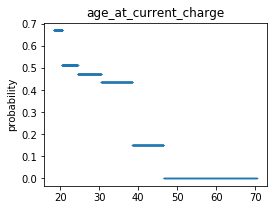

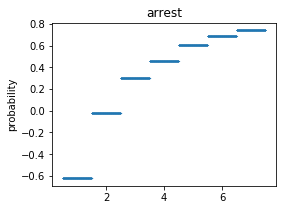

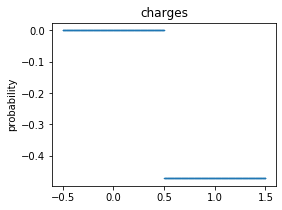

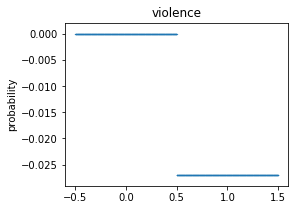

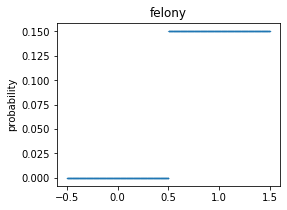

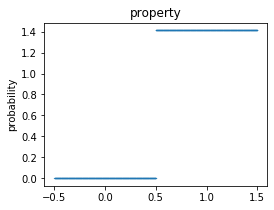

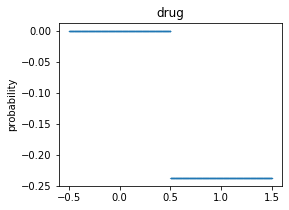

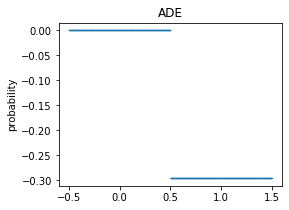

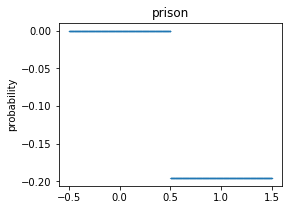

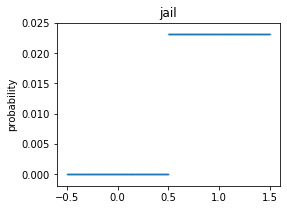

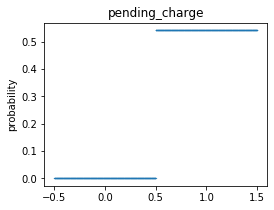

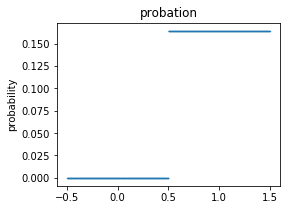

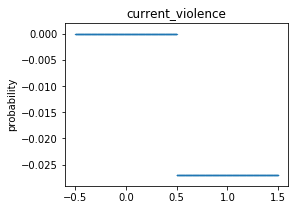

In [19]:
stumps.stump_plots(best_stump_model['features'], best_stump_model['coefs'])

### Arnold PSA

In [20]:
### load data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_data.csv")
X_arnold_raw = data['nca_risk_score_raw'].values
X_arnold_calc = data['nca_calc'].values
Y_arnold = data['recid_property_two_year'].values

In [21]:
## set up cross validation
cv = KFold(n_splits=5,shuffle=True,random_state=816)
raw_auc = []
calc_auc = []

## raw score
i = 1
for train, test in cv.split(X_arnold_raw, Y_arnold):
    y_pred_raw, y_pred_calc, y_test = X_arnold_raw[test], X_arnold_calc[test], Y_arnold[test]
    raw_auc.append(roc_auc_score(y_test, y_pred_raw))
    calc_auc.append(roc_auc_score(y_test, y_pred_calc))
    i+=1 

## RiskSLIM

In [22]:
## load stumps data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_stumps.csv")
x, y = data.loc[:,:'current_violence>=1'], data['recid_property_two_year'].values
cols = x.columns[3:]

In [23]:
## train on best param chosen by Lasso Stumps from above
x_train = x.copy().drop(['race', 'person_id', 'screening_date'], axis=1)
lasso = LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l1', C=0.002, random_state=816).fit(x_train,y)
selected_features = cols[lasso.coef_[0] != 0].tolist()
len(selected_features)

25

In [24]:
### Subset features
if 'sex' in selected_features:
    selected_features = ['recid_property_two_year', 'person_id', 'screening_date', 'race'] + selected_features
    indicator = 1
else:
    selected_features = ['recid_property_two_year', 'person_id', 'screening_date', 'race', 'sex'] + selected_features
    indicator = 0

sub_data = data[selected_features]
sub_X, sub_Y = sub_data.iloc[:,1:], sub_data.iloc[:,0].values
sub_X.insert(0, '(Intercept)', 1)

In [25]:
riskslim_summary = slim.risk_cv(X=sub_X, 
                                Y=sub_Y, 
                                indicator = indicator,
                                y_label='recid_general2', 
                                max_coef=20, 
                                max_coef_number=10, 
                                max_runtime=200, 
                                c=1e-5, 
                                seed=816)

setting c0 = 0.0 to ensure that intercept is not penalized
09/11/19 @ 10:53 AM | 1101 rows in lookup table
09/11/19 @ 10:53 AM | ------------------------------------------------------------
09/11/19 @ 10:53 AM | runnning initialization procedure
09/11/19 @ 10:53 AM | ------------------------------------------------------------
09/11/19 @ 10:53 AM | CPA produced 2 cuts
09/11/19 @ 10:53 AM | running naive rounding on 101 solutions
09/11/19 @ 10:53 AM | best objective value: 0.0791
09/11/19 @ 10:53 AM | rounding produced 5 integer solutions
09/11/19 @ 10:53 AM | best objective value is 0.0814
09/11/19 @ 10:53 AM | running sequential rounding on 101 solutions
09/11/19 @ 10:53 AM | best objective value: 0.0791
09/11/19 @ 10:53 AM | sequential rounding produced 6 integer solutions
09/11/19 @ 10:53 AM | best objective value: 0.0804
09/11/19 @ 10:53 AM | polishing 11 solutions
09/11/19 @ 10:53 AM | best objective value: 0.0804
09/11/19 @ 10:53 AM | polishing produced 5 integer solutions
09/11/

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
09/11/19 @ 10:54 AM | adding 258 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.0804.
Tried aggregator 1 time.
Reduced MIP has 27 rows, 54 columns, and 103 nonzeros.
Reduced MIP has 25 binaries, 27 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.06 ticks)
Probing time = 0.00 sec. (0.02 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.03 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variab

  75156 30508        0.0800     5        0.0802        0.0782   492199    2.56%           rho_4 U  75156  75155     53
  76643 31154        cutoff              0.0802        0.0782   501053    2.56%           rho_5 U  76643  76642     57
  78130 31818        0.0782    13        0.0802        0.0782   509630    2.56%          rho_15 D  78130  78129     28
  79600 32178        0.0793     5        0.0802        0.0782   516581    2.56%          rho_24 D  79600  79599     67
  81070 32506        0.0782    16        0.0802        0.0782   523808    2.56%           rho_7 D  81070  81069     29
  82521 32855        0.0784    13        0.0802        0.0782   530874    2.56%           rho_6 D  82521  82520     66
  83962 33176        0.0793     5        0.0802        0.0782   538057    2.56%          rho_10 D  83962  83959     78
  85391 33487        cutoff              0.0802        0.0782   544988    2.56%           rho_4 U  85391  85390     66
  86835 33835        0.0797     7        0.0802 

 233820 100839        0.0783    17        0.0802        0.0782  1439317    2.56%          rho_15 D 233820 233819     87
 239473 103508        cutoff              0.0802        0.0782  1474770    2.56%          rho_24 U 239473 239472     44
 242928 105390        0.0786    11        0.0802        0.0782  1510908    2.56%           rho_1 D 242928 242927     31
 247044 107772        0.0786    10        0.0802        0.0782  1541968    2.56%          rho_11 D 247044 247042     59
Elapsed time = 133.03 sec. (168152.69 ticks, tree = 39.89 MB, solutions = 3)
 251024 110296        cutoff              0.0802        0.0782  1575702    2.56%          rho_21 U 251024 251023     43
 255295 112512        0.0788    14        0.0802        0.0782  1604805    2.56%          rho_16 U 255295 255293     57
 259708 114993        0.0784    14        0.0802        0.0782  1635371    2.56%           rho_0 D 259708 259679     67
 264089 117164        0.0782    17        0.0802        0.0782  1664662    2.56%   

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
09/11/19 @ 10:57 AM | adding 254 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.0840.
Tried aggregator 1 time.
Reduced MIP has 27 rows, 54 columns, and 103 nonzeros.
Reduced MIP has 25 binaries, 27 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.06 ticks)
Probing time = 0.00 sec. (0.02 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.03 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variab

  94611 42274        0.0823     7        0.0840        0.0820   444109    2.32%          rho_15 D  94611  94610     67
  96485 43031        0.0821    12        0.0840        0.0820   450525    2.31%           rho_0 D  96485  96483     86
  98601 43872        0.0820     7        0.0840        0.0820   458036    2.31%          rho_15 U  98601  98599     61
 100692 44730        0.0821    10        0.0840        0.0821   465425    2.30%          rho_15 U 100692 100678     79
 102950 45583        0.0837     7        0.0840        0.0821   473686    2.30%           rho_5 D 102950 102948     64
 105131 46420        cutoff              0.0840        0.0821   481676    2.30%           rho_9 U 105131 105129     74
Elapsed time = 48.59 sec. (50805.32 ticks, tree = 16.18 MB, solutions = 1)
 107320 47259        0.0821    10        0.0840        0.0821   489698    2.30%          rho_15 U 107320 107308     59
 109255 47992        0.0821    12        0.0840        0.0821   496792    2.30%           rh

 312968 136881        0.0832    10        0.0840        0.0822  1363180    2.14%          rho_10 U 312968 312967     51
 319962 139220        0.0825    18        0.0840        0.0822  1392052    2.13%           rho_0 U 319962 319961     80
Elapsed time = 133.94 sec. (168131.74 ticks, tree = 50.41 MB, solutions = 1)
 327592 142436        cutoff              0.0840        0.0822  1417396    2.13%           rho_1 U 327592 327590     87
 334290 145543        0.0828    11        0.0840        0.0822  1447350    2.13%           rho_0 U 334290 334289     81
 340288 149040        0.0831    11        0.0840        0.0822  1470594    2.13%          rho_14 N 340288 340287     46
 347044 151774        0.0838     7        0.0840        0.0822  1494153    2.12%          rho_21 D 347044 347043     72
 354924 154519        0.0837     8        0.0840        0.0822  1519481    2.12%          rho_21 D 354924 354922     72
 362508 156865        0.0822     9        0.0840        0.0822  1544757    2.12%   

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
09/11/19 @ 11:01 AM | adding 251 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.0825.
Tried aggregator 1 time.
Reduced MIP has 27 rows, 54 columns, and 103 nonzeros.
Reduced MIP has 25 binaries, 27 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.06 ticks)
Probing time = 0.00 sec. (0.02 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.03 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variab

  80150 40905        0.0810     8        0.0825        0.0805   464579    2.43%          rho_16 D  80150  80149     48
  81436 41848        0.0807    14        0.0825        0.0805   475207    2.43%          rho_15 D  81436  81435     64
  82825 42514        cutoff              0.0825        0.0805   485375    2.43%           rho_0 U  82825  82824     67
  84248 42996        0.0808     7        0.0825        0.0805   494996    2.43%           rho_9 D  84248  81836     39
  86129 43693        0.0824     8        0.0825        0.0805   504219    2.43%           rho_0 D  86129  86128     42
  87904 44512        0.0820     5        0.0825        0.0805   515627    2.43%          rho_25 N  87904  87903     65
  89680 45376        0.0805    14        0.0825        0.0805   526692    2.43%           rho_8 U  89680  89661     18
* 90690 45730      integral     0        0.0824        0.0805   532128    2.39%
  91303 45969        0.0822     3        0.0824        0.0805   535204    2.39%        

 242605 128195        0.0811    12        0.0824        0.0805  1571537    2.39%          rho_16 D 242605 242604     40
 247125 131301        0.0805    15        0.0824        0.0805  1611222    2.39%          rho_15 U 247125 247123     58
 252021 133966        0.0805    17        0.0824        0.0805  1648633    2.39%           rho_0 D 252021 251930     72
 257399 137265        0.0805    17        0.0824        0.0805  1684931    2.39%           rho_0 D 257399 257277     52
Elapsed time = 135.13 sec. (168154.81 ticks, tree = 51.03 MB, solutions = 4)
 262760 140568        0.0821    11        0.0824        0.0805  1720249    2.39%           rho_4 U 262760 259030     71
 267212 143109        0.0811    15        0.0824        0.0805  1757441    2.39%           rho_7 D 267212 267210     63
 272229 146323        0.0809    15        0.0824        0.0805  1789050    2.38%           rho_4 D 272229 272228     63
 279404 149466        0.0805    16        0.0824        0.0805  1815138    2.38%   

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
09/11/19 @ 11:04 AM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.0817.
Tried aggregator 1 time.
Reduced MIP has 27 rows, 54 columns, and 103 nonzeros.
Reduced MIP has 25 binaries, 27 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.06 ticks)
Probing time = 0.00 sec. (0.02 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.03 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variab

  67050 27651        0.0796    14        0.0816        0.0794   453079    2.60%           rho_4 D  67050  67049     59
  68398 28279        cutoff              0.0816        0.0794   460943    2.60%          rho_10 U  68398  68397     69
  69785 28868        cutoff              0.0816        0.0794   468163    2.60%           rho_5 D  69785  69783     48
  70893 29361        0.0794    13        0.0816        0.0794   477596    2.60%           rho_0 D  70893  70891     47
  72110 30036        0.0806    14        0.0816        0.0794   486051    2.60%          rho_15 N  72110  72109     32
  73235 30684        cutoff              0.0816        0.0794   495170    2.60%           rho_5 U  73235  73233     35
  74235 31217        0.0812     5        0.0816        0.0794   503259    2.60%          rho_21 D  74235  74233     57
  75210 31736        0.0794    13        0.0816        0.0794   511983    2.60%          rho_15 U  75210  75208     42
Elapsed time = 43.30 sec. (50098.75 ticks, tree 

 189664 90168        0.0805     3        0.0814        0.0794  1400649    2.45%          rho_21 D 189664 189662     42
 193590 92376        0.0794    19        0.0814        0.0794  1429145    2.45%           rho_0 D 193590 193588     45
 197428 94278        0.0807    13        0.0814        0.0794  1456354    2.45%           rho_4 N 197428 163055     32
 201729 96135        0.0794    19        0.0814        0.0794  1489491    2.45%           rho_0 D 201729 201727     65
Elapsed time = 129.56 sec. (166466.82 ticks, tree = 36.78 MB, solutions = 7)
 206249 98048        0.0801     9        0.0814        0.0794  1524633    2.45%          rho_12 N 206249 206248     73
 211555 100744        cutoff              0.0814        0.0794  1557416    2.45%           rho_5 U 211555 211554     66
 216564 103065        0.0808    11        0.0814        0.0794  1591053    2.45%           rho_5 D 216564 216562     38
 220704 105505        0.0794    18        0.0814        0.0794  1629141    2.45%        

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
09/11/19 @ 11:08 AM | adding 251 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.0819.
Tried aggregator 1 time.
Reduced MIP has 27 rows, 54 columns, and 103 nonzeros.
Reduced MIP has 25 binaries, 27 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.06 ticks)
Probing time = 0.00 sec. (0.02 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.03 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variab

  92506 37310        0.0816     5        0.0819        0.0800   370271    2.31%          rho_15 U  92506  92504     45
  94162 38013        cutoff              0.0819        0.0800   375931    2.30%          rho_15 U  94162  94161     41
  95961 38774        0.0801     8        0.0819        0.0800   381504    2.29%           rho_0 D  95961  95959     70
  97744 39394        cutoff              0.0819        0.0800   387276    2.28%           rho_0 U  97744  97743     70
  99414 40044        0.0803    12        0.0819        0.0800   392737    2.27%           rho_6 D  99414  99413     84
 100930 40406        0.0803    12        0.0819        0.0800   398493    2.27%           rho_6 D 100930 100929     84
 102433 40810        0.0800    15        0.0819        0.0800   404480    2.26%           rho_8 U 102433 102006     28
Elapsed time = 32.75 sec. (50686.06 ticks, tree = 15.19 MB, solutions = 3)
 104052 41754        0.0814     5        0.0819        0.0800   410266    2.26%           rh

 293710 113095        cutoff              0.0819        0.0801  1075437    2.15%          rho_24 U 293710 293708     56
 299935 114710        0.0807     9        0.0819        0.0801  1097597    2.15%          rho_22 D 299935 299933     69
Elapsed time = 90.75 sec. (168012.41 ticks, tree = 42.18 MB, solutions = 3)
 306600 117545        0.0812     8        0.0819        0.0801  1118162    2.15%           rho_1 D 306600 306599     69
 313048 121021        0.0801    10        0.0819        0.0801  1135984    2.15%          rho_15 U 313048 313046     45
 319755 124144        0.0814     7        0.0819        0.0801  1158917    2.15%          rho_22 D 319755 319753     85
 326131 127107        0.0812     7        0.0819        0.0801  1182128    2.14%           rho_7 D 326131 326130     67
 331937 129758        cutoff              0.0819        0.0801  1203483    2.14%           rho_0 U 331937 331936     54
 338966 132606        0.0801     7        0.0819        0.0801  1225358    2.14%    

 678708 271906        0.0804     7        0.0819        0.0802  2479761    2.05%           rho_7 D 678708 678707     88
 684917 274607        0.0802    12        0.0819        0.0802  2499639    2.05%           rho_0 D 684917 684915     71
 690601 277707        cutoff              0.0819        0.0802  2519426    2.05%          rho_14 U 690601 690600     55

User cuts applied:  1035

Root node processing (before b&c):
  Real time             =    0.09 sec. (1.39 ticks)
Sequential b&c:
  Real time             =  199.92 sec. (414228.20 ticks)
                          ------------
Total (root+branch&cut) =  200.02 sec. (414229.59 ticks)
+----------------------------------------------+------------------+-----------+
| Pr(Y = +1) = 1.0/(1.0 + exp(-(-6 + score))   |                  |           |
| ============================================ | ================ | ========= |
| p_property>=1                                |         2 points |   + ..... |
| age_at_current_charge<=19          

In [26]:
np.mean(riskslim_summary['train_auc']), np.mean(riskslim_summary['test_auc'])

(0.7542522545118999, 0.7516639230455825)

### Results

In [27]:
#### save results
summary_property2_KY_interpret = {"CART": cart_summary,
                                   "EBM": ebm_summary, 
                                   'Lasso Stumps': stump_summary, 
                                   'RiskSLIM': riskslim_summary, 
                                   'Arnold PSA Raw': raw_auc, 
                                   'Arnold PSA': calc_auc}
%store summary_property2_KY_interpret

Stored 'summary_property2_KY_interpret' (dict)


In [28]:
results = [["CART", np.mean(cart_summary['holdout_test_auc']), np.mean(cart_summary['auc_diffs'])],
           ["EBM", np.mean(ebm_summary['holdout_test_auc']), np.mean(ebm_summary['auc_diffs'])], 
           ["Lasso Stumps", np.mean(stump_summary['holdout_test_auc']), np.mean(stump_summary['auc_diffs'])],
           ['RiskSLIM', np.mean(riskslim_summary['test_auc'])],
           ['Arnold PSA Raw', round(np.mean(raw_auc), 3)], 
           ['Arnold PSA', round(np.mean(calc_auc), 3)]]
results

[['CART', 0.77231127184065, 0.01633649264435062],
 ['EBM', 0.786986977866176, 0.014281743498652277],
 ['Lasso Stumps', 0.7890590642872922, 0.002607485488434258],
 ['RiskSLIM', 0.7516639230455825],
 ['Arnold PSA Raw', 0.724],
 ['Arnold PSA', 0.698]]

In [29]:
auc = [np.mean(cart_summary['holdout_test_auc']), 
       np.mean(ebm_summary['holdout_test_auc']), 
       np.mean(stump_summary['holdout_test_auc']), 
       np.mean(riskslim_summary['test_auc'])]

In [30]:
path = "C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY Results/Models/Two Year/"
results = [["Property", np.str((round(np.mean(cart_summary['holdout_test_auc']), 3))) + " (" + np.str(round(np.std(cart_summary['holdout_test_auc']), 3)) + ")", 
            np.str(round(np.mean(ebm_summary['holdout_test_auc']),3)) + " (" + np.str(round(np.std(ebm_summary['holdout_test_auc']), 3)) + ")", 
            np.str(round(np.mean(stump_summary['holdout_test_auc']),3)) + " (" + np.str(round(np.std(stump_summary['holdout_test_auc']), 3)) + ")",             
            np.str(round(np.mean(riskslim_summary['test_auc']),3)) + " (" + np.str(round(np.std(riskslim_summary['test_auc']), 3)) + ")", 
            round(np.max(auc) - np.min(auc), 3),
            np.str(round(np.mean(raw_auc), 3)) + " (" + np.str(round(np.std(raw_auc),3)) + ")", 
            np.str(round(np.mean(calc_auc), 3)) + " (" + np.str(round(np.std(calc_auc),3)) + ")"]]
with open(path + 'Interpretable Models Summary.csv', 'a') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(results)